# NeuralEE on HEMATO Dataset

`HEMATO` Dataset includes 4,016 cells from two batches that were profiled using in-drop. This data provides a snapshot of hematopoietic progenitor cells differentiating into various lineages.

In [1]:
import random
import numpy as np
import torch

from neuralee.embedding import NeuralEE
from neuralee.dataset import HematoDataset
from neuralee._aux import scatter_with_colorbar

%matplotlib inline

Choose a GPU if a GPU available. It could be defined as follow:
```
device = torch.device('cuda:0')
device = torch.device('cuda:1')
device = torch.device('cpu')
```

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

To reproduce the following results, fix the random seed.

In [3]:
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

First, we apply log(1 + x) transformation to each element of the cell-gene expression matrix. 
Then, We retain top 500 genes ordered by variance. 
Finally, we normalize the expression of each gene by subtracting its mean and dividing its standard deviation.

In [4]:
hemato_dataset = HematoDataset(save_path='../HEMATO/')
hemato_dataset.log_shift()
hemato_dataset.subsample_genes(500)  
hemato_dataset.standardscale()

File ../HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File ../HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data
Downsampling from 7397 to 500 genes


We apply NeuralEE with different hyper-paramters.
`N_small` takes from {1.0, 0.5, 0.25}, while `N_smalls`= 1.0 means not applied with stochastic optimization.
`lam` takes from {1, 10}.
`perplexity` fixs as 30.

Compute affinity, perplexity=30.0, on entire dataset
Compute affinity, perplexity=30.0, N_small=4016, on each batch
Neural Elastic Embedding, lambda=1, completed in 5.17s.
Neural Elastic Embedding, lambda=10, completed in 3.30s.
Compute affinity, perplexity=30.0, N_small=2008, on each batch
Neural Elastic Embedding, lambda=1, completed in 4.54s.
Neural Elastic Embedding, lambda=10, completed in 4.56s.
Compute affinity, perplexity=30.0, N_small=1004, on each batch
Neural Elastic Embedding, lambda=1, completed in 8.94s.
Neural Elastic Embedding, lambda=10, completed in 8.95s.


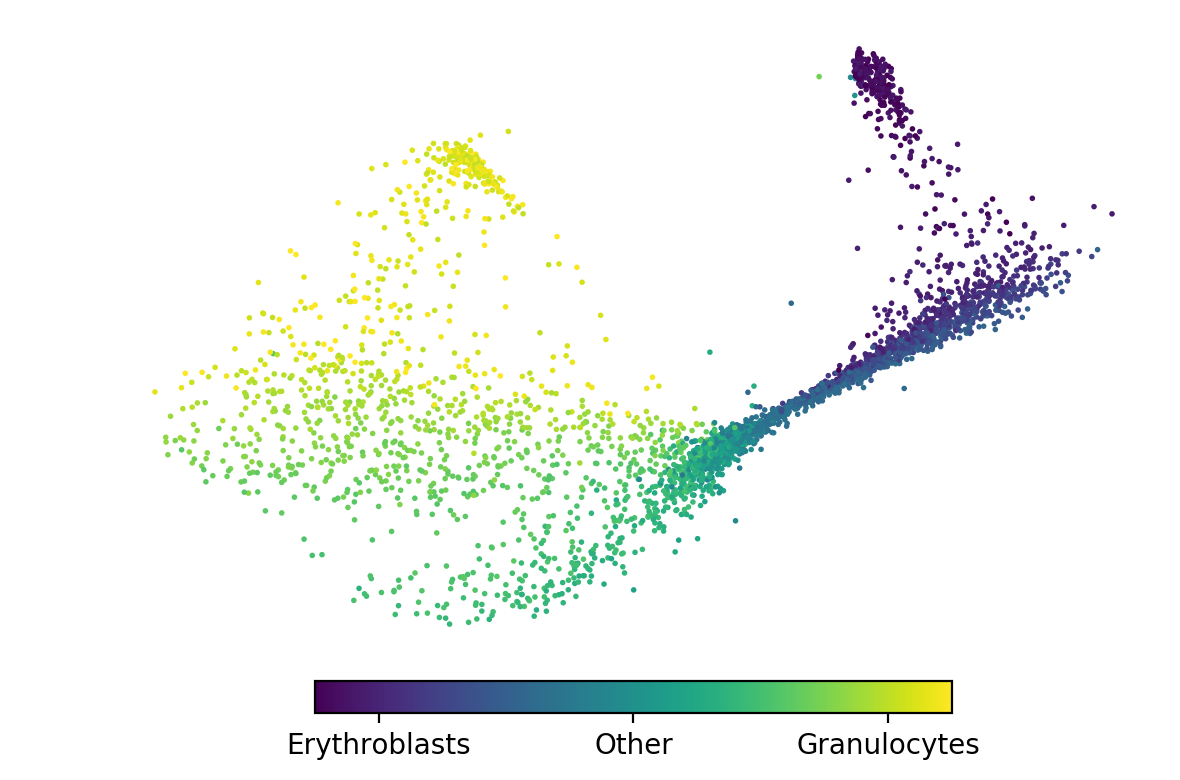

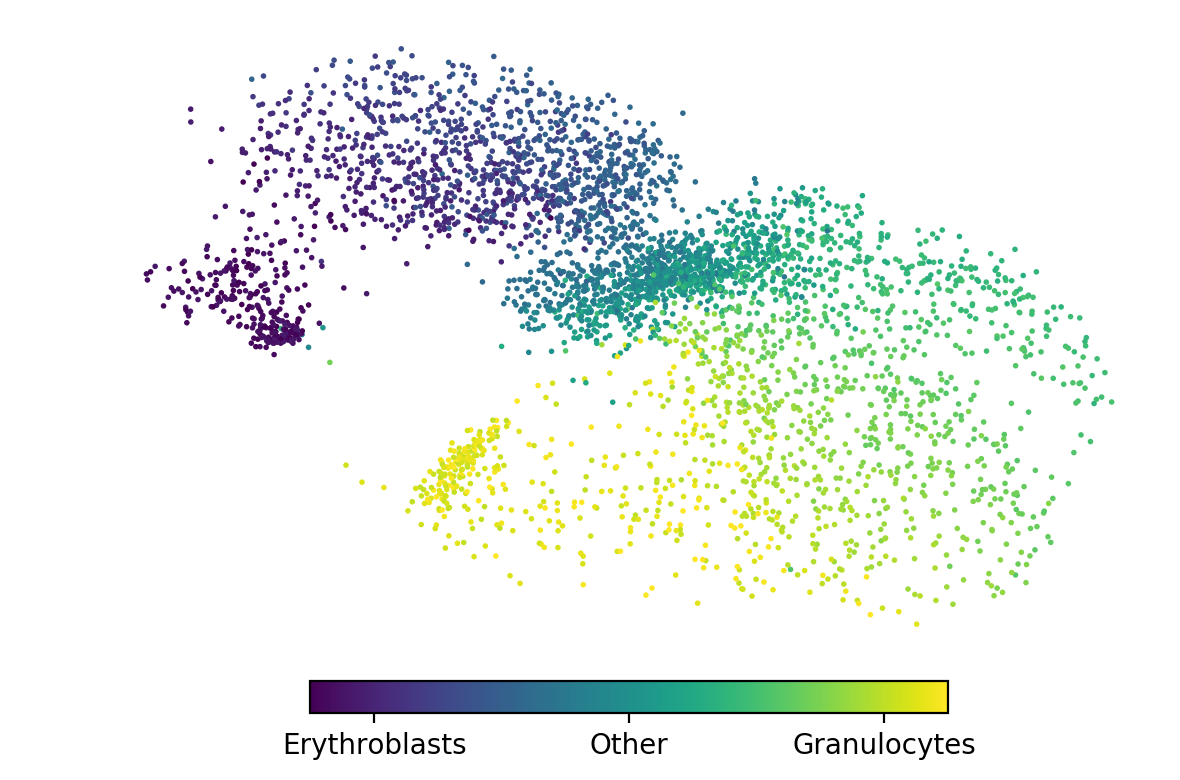

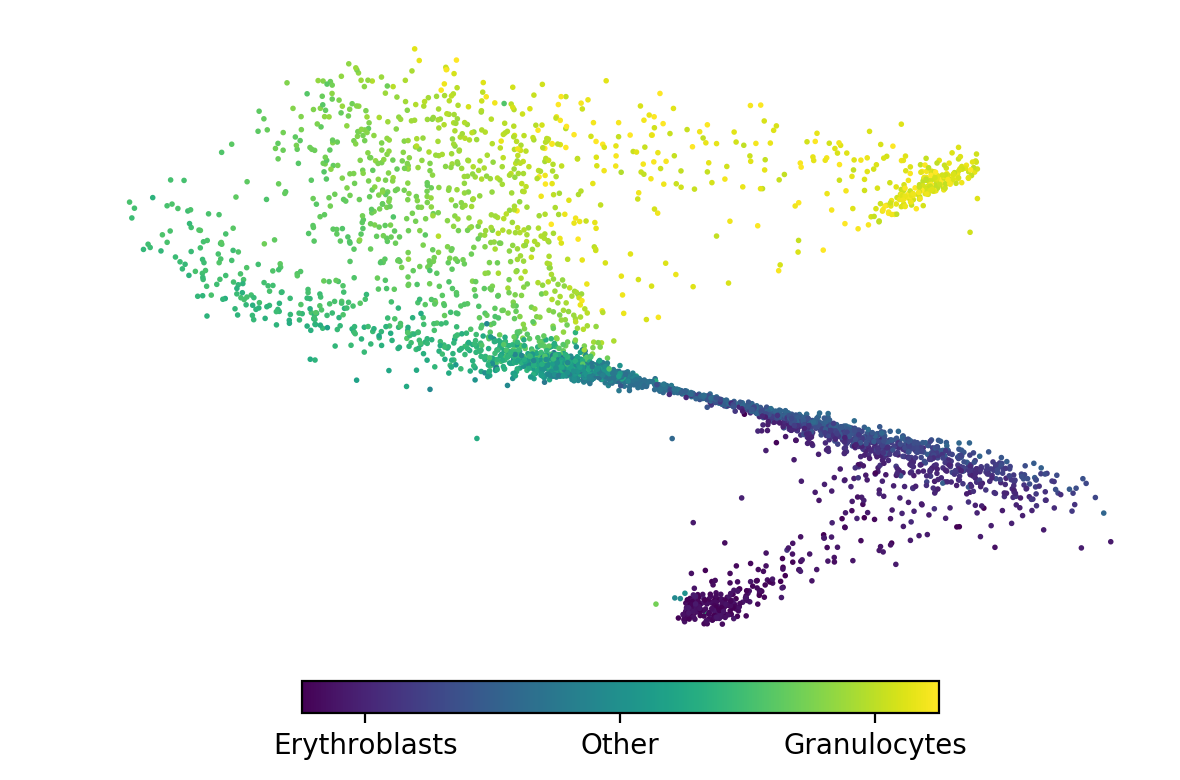

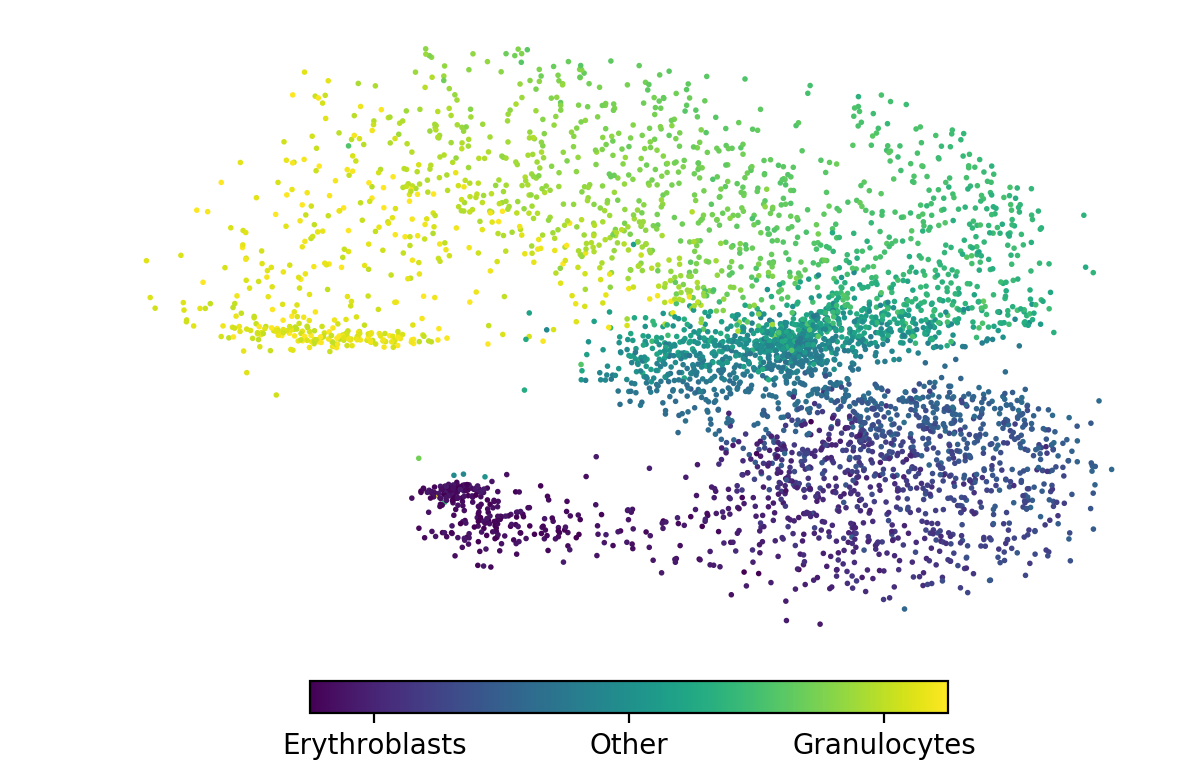

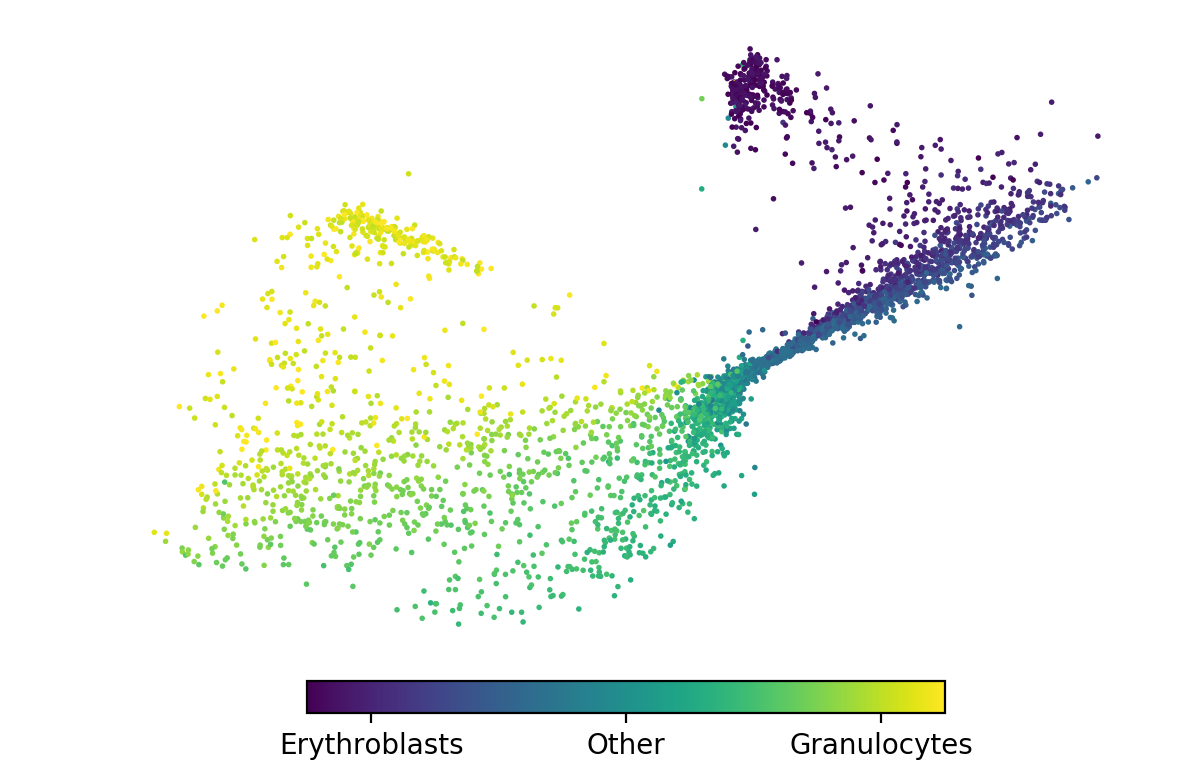

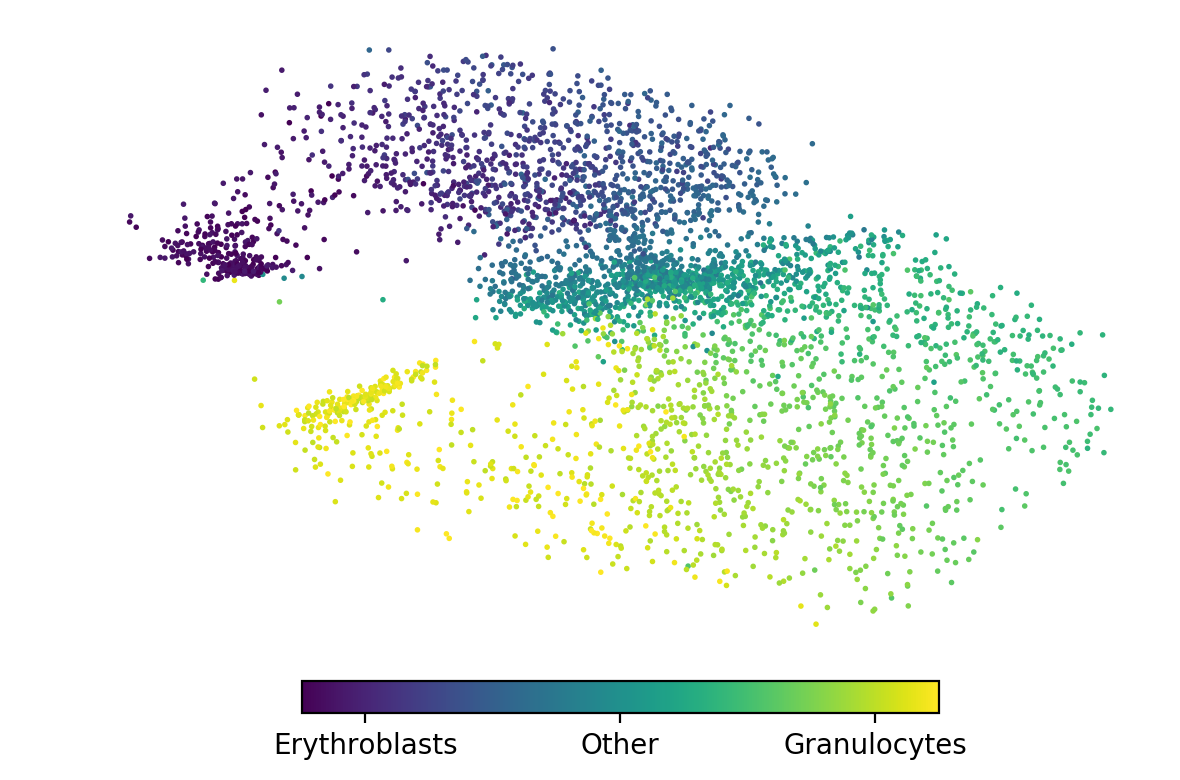

In [5]:
N_smalls = [1.0, 0.5, 0.25]
N_str = ["nobatch", "2batches", "4batches"]
lams = [1, 10]

hemato_dataset.affinity(perplexity=30.0)
for i in range(len(N_smalls)):
    hemato_dataset.affinity_split(N_small=N_smalls[i], perplexity=30.0)
    for lam in lams:
        NEE = NeuralEE(hemato_dataset, lam=lam, device=device)
        results_Neural = NEE.fine_tune()
        np.save('embedding/HEMATO_' + 'lam' + str(lam) + '_' + N_str[i], results_Neural['X'].numpy())
        scatter_with_colorbar(
            results_Neural['X'].numpy(), NEE.labels, ['Erythroblasts', 'Granulocytes'])